## Hyperparameters

In [1]:
EPOCH = 6
BATCH_SIZE = 20
LEARNING_RATE = 1e-3
THRESHOLD = 0.5
DROPOUT_RATE = 0.1

CONTEXT_MAX_LEN = 300
RESPONSE_MAX_LEN = 30

LOGISTICLOSS = True
BUILD_NEW_DICT = True

# Import package

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from tqdm import trange
from itertools import repeat
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import re
import sys
import pandas as pd
import scipy.sparse as sp
import numpy as np
import json
import math
import os
import torch.nn as nn
import torch.nn.functional as F
import pickle
import json

## Data Overview

### load train & test

In [3]:
import json

with open('train.json') as f:
    train_raw = json.load(f)
    
with open('test.json') as f:
    test_raw = json.load(f)

In [4]:
import pprint
pprint.pprint(train_raw[0])

{'data-split': 'train',
 'example-id': 1000001,
 'messages-so-far': [{'speaker': 'participant_1',
                      'utterance': 'Hi, I want to run a graphical application '
                                   'from the command line, here is the script '
                                   'I wrote: https://paste8.com/4XQiHrXZ - '
                                   "it's Ubuntu Server 12.04 + Unity. What I "
                                   'get is an error from xhost "unable to open '
                                   'display :0" and from the graphical '
                                   'application I want to use (Sikuli) "Can\'t '
                                   "connect to X11 window server using ':0' as "
                                   'the value of the DISPLAY variable.". I\'ve '
                                   'tried using DISPLAY:=1 as I use this '
                                   'number when connecting with a VNC client '
                                   

In [5]:
import spacy
spacy.prefer_gpu()


nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])

def tokenizer(text):
    return [token.text.strip() for token in nlp(text)]


## split train and valid 

In [6]:
from sklearn.model_selection import train_test_split

print('# of origin training data:',len(train_raw))

train_raw, valid_raw = train_test_split(train_raw, test_size=0.2, shuffle=False)

print('# of train data:',len(train_raw))
print('# of valid data:',len(valid_raw))
print('# of test data:',len(test_raw))

# of origin training data: 100000
# of train data: 80000
# of valid data: 20000
# of test data: 2000


## Preprocess for train

In [7]:
def preprocess(data_list, description):
    """
    preprocess from json file to dataframe format
    with three columns: dialogue, response, label (only training data)
    dialogue are added special token
    
    """
    dialogues = []
    reponses = []
    if description=='train' or description=='valid':
        labels = []
    
    for i,data in enumerate(data_list):
        dialogue = []
        
        # choose previous n turns of utterance to enhance the performance
        messages_so_far_list = data['messages-so-far']#[-TURN_LIMIT:]
        
        for record_dict in messages_so_far_list:
            utterance_i = record_dict['utterance']
            speaker_i = record_dict['speaker'][-1]
            # split utterance into tokens
            utterance_i = tokenizer(utterance_i)
            dialogue+=utterance_i
            dialogue.append('eou')
        dialogue.append('sep')
        
        dialogue = ' '.join(dialogue[-CONTEXT_MAX_LEN:])
        
        if description=='train' or description=='valid':
              
            # positive sample
            dialogues.append(dialogue)
            
            correct_response = data['options-for-correct-answers'][0]['utterance']  
            correct_response = ' '.join(tokenizer(correct_response)[:RESPONSE_MAX_LEN])
            reponses.append(correct_response)
        
            label = 1
            labels.append(label)
            

            # negative sample
            correct_answers = data['options-for-correct-answers'][0]
            candidates = data['options-for-next']
            if correct_answers in candidates:
                candidates.remove(correct_answers)
            
            # train
            if description=='train':
                for i in range(4): 
                    dialogues.append(dialogue)

                    #idx = np.random.choice(len(candidates))
                    resposne = data['options-for-next'][i]['utterance']
                    resposne = ' '.join(tokenizer(resposne)[:RESPONSE_MAX_LEN])
                    reponses.append(resposne)

                    label = 0
                    labels.append(label)
            
            # valid
            else:
                for candidate in candidates:
                    dialogues.append(dialogue)
                    resposne = candidate['utterance']
                    resposne = ' '.join(tokenizer(resposne)[:RESPONSE_MAX_LEN])
                    reponses.append(resposne)

                    label = 0
                    labels.append(label)

        
        else: # test #valid
            candidates = data['options-for-next']
            for candidate in candidates:
                dialogues.append(dialogue)
                
                response = candidate['utterance']
                response = ' '.join(tokenizer(response)[:RESPONSE_MAX_LEN])
                reponses.append(response)
                
                
    
    if description=='train' or description=='valid':
        df = pd.DataFrame(zip(dialogues, reponses, labels), columns=['context','response','label'])
        return df
    
    else:
        df = pd.DataFrame(zip(dialogues,reponses), columns=['context','response'])
        return df

In [8]:
len(valid_raw)

20000

In [9]:
%%time
trainset = preprocess(train_raw, 'train')
validset = preprocess(valid_raw, 'valid')
testset = preprocess(test_raw, 'test')

CPU times: user 3min 10s, sys: 500 ms, total: 3min 10s
Wall time: 3min 8s


In [10]:
print(len(trainset))
trainset.head(10)

400000


,context,response,label
0,"I kill precisely ? because it says "" X : no su...",are you still running in root terminal ? if so...,1
1,"I kill precisely ? because it says "" X : no su...",quite,0
2,"I kill precisely ? because it says "" X : no su...",hey join # . so i can tell you things that th...,0
3,"I kill precisely ? because it says "" X : no su...",did you complete the ubuntu installation ? ?,0
4,"I kill precisely ? because it says "" X : no su...",how did you run mplayer ?,0
5,how do I turn on optical output under gutsy ? ...,oh cool :),1
6,how do I turn on optical output under gutsy ? ...,"does it still run . check top or "" ps aux """,0
7,how do I turn on optical output under gutsy ? ...,then how do you know it does nt work out of th...,0
8,how do I turn on optical output under gutsy ? ...,Quanta maybe ? http://quanta.kdewebdev.org/,0
9,how do I turn on optical output under gutsy ? ...,- > are you using any encryption too . ?,0


In [11]:
print(len(validset))
validset.head(101)

2000000


,context,response,label
0,No help to as why I ca n't install things ? eo...,pgrep -l apt - get,1
1,No help to as why I ca n't install things ? eo...,Kismet is made up by two parts . The server ki...,0
2,No help to as why I ca n't install things ? eo...,One sec . https://help.ubuntu.com/community/W...,0
3,No help to as why I ca n't install things ? eo...,"ah , xkill",0
4,No help to as why I ca n't install things ? eo...,Thankyou i 'll have a read of it right now :),0
...,...,...,...
96,No help to as why I ca n't install things ? eo...,it 's been many years since I messed with that...,0
97,No help to as why I ca n't install things ? eo...,- you can do it a few ways ... set the group o...,0
98,No help to as why I ca n't install things ? eo...,gksu gedit /etc / hosts . comment out ( put a...,0
99,No help to as why I ca n't install things ? eo...,time to be reading up on that ' using samba ' ...,0


In [12]:
print(len(testset))
testset.head(10)

200000


,context,response
0,I 'm starting to get really pissed off here . ...,apt - get remove whatever .. :) or just edit t...
1,I 'm starting to get really pissed off here . ...,not all makes are created equally . you might ...
2,I 'm starting to get really pissed off here . ...,what ?
3,I 'm starting to get really pissed off here . ...,yes
4,I 'm starting to get really pissed off here . ...,the items I see under the scroll bar there are...
5,I 'm starting to get really pissed off here . ...,do you have 2 video cards installed ?
6,I 'm starting to get really pissed off here . ...,"according to apt - cache search , it 's in xmm..."
7,I 'm starting to get really pissed off here . ...,the first one
8,I 'm starting to get really pissed off here . ...,some nights it has me in stiches . that and i...
9,I 'm starting to get really pissed off here . ...,sweet ai nt it :D


#### check CONTEXT_MAX_LEN<=300 & RESPONSE_MAX_LEN <= 30

In [13]:
dataset = trainset
print('context len:',len(dataset.loc[0,'context'].split()))
print('response len:',len(dataset.loc[0,'response'].split()))

context len: 297
response len: 30


## Counting word

In [14]:
from multiprocessing import Pool
from nltk.tokenize import word_tokenize


def splitwords(text):
    return text.split()
    

def collect_words(df, n_workers=4):        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['context'].split('eou')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(splitwords, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [15]:
%%time 
import pickle

if not os.path.exists('saved_files'):
    os.mkdir('saved_files')

if os.path.isfile('saved_files/dicitonary.pkl') and not BUILD_NEW_DICT:
    print('Load existing dictionary')
    with open('saved_files/dicitonary.pkl','rb') as f:
        words = pickle.load(f)
        
else:

    print('creat new dictionary')
    words = set()
    words |= collect_words(trainset)
    word_dict = {}
    for word in words: 
        word_dict[word]=len(word_dict)

    with open('saved_files/dicitonary.pkl','wb') as f:
        pickle.dump(word_dict, f)

creat new dictionary
CPU times: user 36.4 s, sys: 1.65 s, total: 38.1 s
Wall time: 40.8 s


## restart run below

## Embedding class to save pretrained embedding

In [16]:
import re
import torch

class Embedding:
    """
    Args:
        embedding_path (str): Path where embedding are loaded from (text file).
        words (None or list): If not None, only load embedding of the words in
            the list.
        oov_as_unk (bool): If argument `words` are provided, whether or not
            treat words in `words` but not in embedding file as `<unk>`. If
            true, OOV will be mapped to the index of `<unk>`. Otherwise,
            embedding of those OOV will be randomly initialize and their
            indices will be after non-OOV.
        lower (bool): Whether or not lower the words.
        rand_seed (int): Random seed for embedding initialization.
    """

    def __init__(self, embedding_path,
                 words=None, oov_as_unk=True, lower=True, rand_seed=524):
        self.word_dict = {}
        self.vectors = None
        self.lower = lower
        self.extend(embedding_path, words, oov_as_unk)
        torch.manual_seed(rand_seed)

        if '<pad>' not in self.word_dict:
            self.add(
                '<pad>', torch.zeros(self.get_dim())
            )
        
        if '<bos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<bos>', t_tensor
            )
            
        if '<eos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eos>', t_tensor
            )
        
        if '<eou>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eou>', t_tensor
            )
        
        if '<sep>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<sep>', t_tensor
            )
        
        if '<unk>' not in self.word_dict:
            self.add('<unk>')

    def to_index(self, word):
        """
        Args:
            word (str)

        Return:
             index of the word. If the word is not in `words` and not in the
             embedding file, then index of `<unk>` will be returned.
        """
        if self.lower:
            word = word.lower()

        if word not in self.word_dict:
            return self.word_dict['<unk>']
        else:
            return self.word_dict[word]

    def get_dim(self):
        return self.vectors.shape[1]

    def get_vocabulary_size(self):
        return self.vectors.shape[0]

    def add(self, word, vector=None):
        if self.lower:
            word = word.lower()

        if vector is not None:
            vector = vector.view(1, -1)
        else:
            vector = torch.empty(1, self.get_dim())
            torch.nn.init.uniform_(vector)
        self.vectors = torch.cat([self.vectors, vector], 0)
        self.word_dict[word] = len(self.word_dict)

    def extend(self, embedding_path, words, oov_as_unk=True):
        self._load_embedding(embedding_path, words)

        if words is not None and not oov_as_unk:
            # initialize word vector for OOV
            for word in words:
                if self.lower:
                    word = word.lower()

                if word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict)

            oov_vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict) - self.vectors.shape[0],
                            self.vectors.shape[1]))

            self.vectors = torch.cat([self.vectors, oov_vectors], 0)

    def _load_embedding(self, embedding_path, words):
        if words is not None:
            words = set(words)

        vectors = []

        with open(embedding_path) as fp:

            row1 = fp.readline()
            # if the first row is not header
            if not re.match('^[0-9]+ [0-9]+$', row1):
                # seek to 0
                fp.seek(0)
            # otherwise ignore the header

            for i, line in enumerate(fp):
                cols = line.rstrip().split(' ')
                word = cols[0]

                # skip word not in words if words are provided
                if words is not None and word not in words:
                    continue
                elif word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict)
                    vectors.append([float(v) for v in cols[1:]])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors


In [17]:
%%time
import os
import pickle


if os.path.isfile('saved_files/embedding.pkl') and not BUILD_NEW_DICT:
    print('Load existing embedding')
    with open('saved_files/embedding.pkl','rb') as f:
        embedder = pickle.load(f)
else:
    print('new embedding')

    embedder = Embedding('glove.6B.300d.txt', words)
    with open('saved_files/embedding.pkl','wb') as f:
        pickle.dump(embedder, f)

new embedding
CPU times: user 7.89 s, sys: 205 ms, total: 8.1 s
Wall time: 7.52 s


In [18]:
len(embedder.word_dict)

26372

## Data formatting

In [19]:
from tqdm import tqdm_notebook as tqdm

def label_to_onehot(label):
    onehot = [0,0]
    onehot[int(label)] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    indices = []
    for word in sentence.split():
        if word in ['eou','sep']:
            word = '<{}>'.format(word)
        indices.append(word_dict.to_index(word))
    return indices
    #return [word_dict.to_index(word) for word in word_tokenize(sentence)]
    
def get_dataset(dataset, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    #dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['context'] = sentence_to_indices(data['context'], word_dict)# for sent in data['context'].split('eou')]
    processed['response'] = sentence_to_indices(data['response'], word_dict)
    if 'label' in data:
        #processed['label'] = label_to_onehot(data['label'])
        processed['label'] = int(data['label'])
        
        
    return processed

In [20]:
%%time
if not BUILD_NEW_DICT and os.path.exists('saved_files/train.pkl') and os.path.exists('saved_files/valid.pkl') and os.path.exists('saved_files/test.pkl'):
    print('Load existing train, valid, test')
    with open('saved_files/train.pkl','rb') as f:
        train = pickle.load(f)
    with open('saved_files/valid.pkl','rb') as f:
        valid = pickle.load(f) 
    with open('saved_files/test.pkl','rb') as f:
        test = pickle.load(f)

else:

    print('[INFO] Start processing trainset...')
    train = get_dataset(trainset, embedder, n_workers=4)
    print('[INFO] Start processing validset...')
    valid = get_dataset(validset, embedder, n_workers=4)
    print('[INFO] Start processing testset...')
    test = get_dataset(testset, embedder, n_workers=4)

    with open('saved_files/train.pkl','wb') as f:
        pickle.dump(train,f)
    with open('saved_files/valid.pkl','wb') as f:
        pickle.dump(valid,f) 
    with open('saved_files/test.pkl','wb') as f:
        pickle.dump(test,f)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...




CPU times: user 32.6 s, sys: 5.81 s, total: 38.4 s
Wall time: 2min 24s


#### check formatting

In [21]:
print('context len:',len(list(train)[0]['context']))
print('response len:',len(list(train)[0]['response']))

context len: 297
response len: 30


## Data packing

In [22]:
from torch.utils.data import Dataset
import torch

class dialogueDataset(Dataset):
    def __init__(self, data, pad_idx):#, max_len=MAX_SENTENCE_LEN):
        self.data = data
        self.pad_idx = pad_idx
        #self.max_len = max_len
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):

        max_len_context = max([len(data['context']) for data in datas])
        max_len_response = max([len(data['response']) for data in datas])

        batch_context = []
        batch_response = []
        batch_label = []
        #sent_len = []
        
        for data in datas:
            #sent_len.append(len(data['context']))
            
            # dialogue
            if len(data['context']) < max_len_context:
                data['context'] += [self.pad_idx]*(max_len_context-len(data['context']))
            batch_context.append(data['context'])
            
            # response
            if len(data['response']) < max_len_response:
                data['response'] += [self.pad_idx]*(max_len_response-len(data['response']))
            batch_response.append(data['response'])
            
            # labels
            if 'label' in data:
                batch_label.append(data['label'])
                
        return torch.LongTensor(batch_context), torch.LongTensor(batch_response), torch.FloatTensor(batch_label)




In [23]:
PAD_TOKEN = embedder.word_dict['<pad>']

trainData = dialogueDataset(train, PAD_TOKEN)
validData = dialogueDataset(valid, PAD_TOKEN)
testData = dialogueDataset(test, PAD_TOKEN)

In [24]:
len(validData)

2000000

In [45]:
i2w = {v:k for k,v in embedder.word_dict.items()} 

In [53]:
data_i = 1

#### context

In [54]:
validset.loc[data_i,'context']

"No help to as why I ca n't install things ? eou what package manager were you using ? eou I was using sudo apt - get on Kubuntu . ( I 'd try their irc , but hardly anyone is around . ) eou sep"

In [55]:
' '.join([i2w[idx] for idx in list(validData)[data_i]['context']])

"no help to as why i ca n't install things ? <eou> what package manager were you using ? <eou> i was using sudo apt - get on kubuntu . ( i 'd try their irc , but hardly anyone is around . ) <eou> <sep>"

#### resposne

In [56]:
validset.loc[data_i,'response']

'Kismet is made up by two parts . The server kismet_server and client , kismet_client . Have you configured the server part ?'

In [57]:
' '.join([i2w[idx] for idx in list(validData)[data_i]['response']])

'kismet is made up by two parts . the server <unk> and client , <unk> . have you configured the server part ?'

## Model

In [25]:
def LocalMatching(c,r):
    e_ij = torch.matmul(c,r.transpose(1,2)) # (x timestep) * (r timestep)
    alpha_ij = F.softmax(e_ij, dim=2) 
    beta_ij = F.softmax(e_ij, dim=1)

    c_d = torch.matmul(alpha_ij, r)
    r_d = torch.matmul(beta_ij.transpose(1,2), c)
    
    c_l = torch.cat([c, c_d, c - c_d, c * c_d], dim=1) #hidden_size*2 *4
    r_l = torch.cat([r, r_d, r - r_d, r * r_d], dim=1)

    return c_l, r_l

In [26]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class crossAtteNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(crossAtteNet, self).__init__()
        self.hidden_dim = 300
        self.rnn1 = nn.GRU(vocabulary_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True,
                                num_layers=2,
                                dropout=DROPOUT_RATE)
        
        self.rnn2 = nn.GRU(self.hidden_dim*2,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True,
                                num_layers=2,
                                dropout=DROPOUT_RATE)
        
        self.MLP = nn.Sequential(
                        nn.Dropout(DROPOUT_RATE),
                        nn.ReLU(),
                        nn.Linear(self.hidden_dim*2*4, 256),
                        nn.Dropout(DROPOUT_RATE),
                        nn.ReLU(),
                        nn.Linear(256, 16),
                        nn.Dropout(DROPOUT_RATE),
                        nn.ReLU(),
                        nn.Linear(16, 1),
                    )


    def forward(self, context, response):
        batchsize = context.size(0)
        # Input Encoding
        context,  _ = self.rnn1(context) # shape: (batchsize, seq_len, hidden_size*2) -->bidirectional
        response, _ = self.rnn1(response)
        
        # Local Matching
        c_l, r_l = LocalMatching(context,response) # shape: (batchsize, seq_len*4, hidden_size*2)
        
        # Matching Composition
        context,  _ = self.rnn2(c_l)  # shape: (batchsize, seq_len*4, hidden_size*2)
        response, _ = self.rnn2(r_l)
        
        # Pooling shape: (batchsize, hidden_size*2)
        c_max_pool = F.adaptive_max_pool1d(context.permute(0,2,1),1).view(batchsize,-1) 
        c_avg_pool = F.adaptive_avg_pool1d(context.permute(0,2,1),1).view(batchsize,-1)
        
        r_max_pool = F.adaptive_max_pool1d(response.permute(0,2,1),1).view(batchsize,-1)
        r_avg_pool = F.adaptive_avg_pool1d(response.permute(0,2,1),1).view(batchsize,-1)
        
        x = torch.cat([c_max_pool, c_avg_pool, r_max_pool, r_avg_pool], dim=1) # shape: (batchsize, hidden_size*2*4)
        x = self.MLP(x)
        
        return x

# Training

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
class F1():
    def __init__(self):
        self.threshold = THRESHOLD
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'
        
        self.N = 0
        self.correct = 0

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        
        self.N = 0
        self.correct = 0
        
    def update(self, predicts, groundTruth, update100=False):
        if update100:
            self.N += groundTruth
            self.correct += predicts
            return 
            
        if LOGISTICLOSS:
            predicts = torch.sigmoid(predicts)
        predicts = predicts > self.threshold
        
        self.correct += torch.sum(predicts==groundTruth).data.item()
        self.N += len(predicts)

    def get_score(self):
        return self.correct/self.N

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [29]:
import os


def _run_epoch(epoch, embedding, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
        predict_list = []
        label_list = []
    dataloader = DataLoader(dataset=dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)
   
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, r, y) in trange:
        x = embedding(x)
        r = embedding(r)
        o_labels, batch_loss = _run_iter(x,r,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        
        if training:
            f1_score.update(o_labels.cpu(), y)
            trange.set_postfix(loss=loss / (i + 1), f1=f1_score.print_score())
            
        if not training: 
            predict_list,label_list, f1_score = collect100(predict_list,label_list,o_labels.cpu(), y, f1_score)
            if not predict_list and not label_list:
                trange.set_postfix(loss=loss / (i + 1), f1=f1_score.print_score())
        
       
    if training:
        history['train'].append({'accuracy':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'accuracy':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,r,y):
    x = x.to(device)
    r = r.to(device)
    labels = y.to(device)
    
    o_labels = model(x,r)
    o_labels = o_labels.flatten()
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [30]:
def collect100(predict_list, label_list, o_labels, y, f1_score):
    predict_list.append(o_labels)
    label_list.append(y)
    
    if len(torch.cat(predict_list))==100 and len(torch.cat(label_list))==100:
        pred = torch.cat(predict_list)
        label = torch.cat(label_list)
        if sum(pred==label).data.item()==100:
            predicts = 1
        else:
            predicts = 0
        groundTruth = 1
        f1_score.update(predicts, groundTruth, True)
        predict_list = []
        label_list = []
    
    return predict_list, label_list, f1_score

In [31]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = crossAtteNet(embedder.get_dim())
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

if LOGISTICLOSS:
    criteria = torch.nn.BCEWithLogitsLoss()
else:
    criteria = torch.nn.BCELoss()


model.to(device)
max_epoch = EPOCH
history = {'train':[],'valid':[]}


embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim())
embedding.weight = torch.nn.Parameter(embedder.vectors)

## traaaaaaaaaaaaaain

In [32]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, embedding, True)
    _run_epoch(epoch, embedding, False)
    save(epoch)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5


# Plot

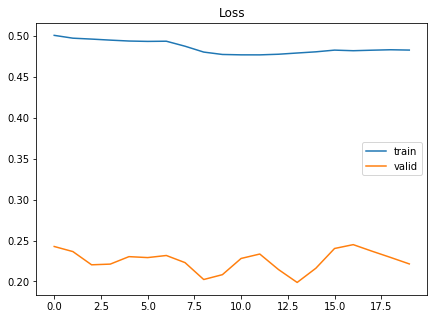

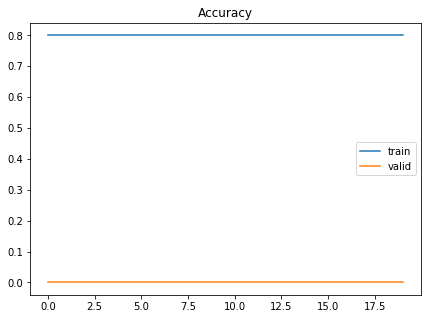

Best Accuracy score  [0.0, 19]


In [34]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['accuracy'] for l in history['train']]
valid_f1 = [l['accuracy'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('Accuracy')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best Accuracy score ', max([[l['accuracy'], idx] for idx, l in enumerate(history['valid'])]))

## Predict

In [32]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [35]:
model_id = 13
model.load_state_dict(torch.load('model/model.pkl.{}'.format(model_id)))
model.train(False)
_run_epoch(1, embedding, False)


dataloader = DataLoader(dataset=testData,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
pred_tmp = []
for i, (x,r,y) in trange:
    x = embedding(x)
    r = embedding(r)
    o_labels = model(x.to(device),r.to(device))
    if LOGISTICLOSS:
        o_labels = torch.sigmoid(o_labels)
    o_labels_list = list(o_labels.cpu().detach().numpy())
    pred_tmp += o_labels_list
    if len(pred_tmp)==100:
        idx = pred_tmp.index(max(pred_tmp))
        prediction.append(idx)
        pred_tmp = []


In [36]:
len(prediction)

2000

In [37]:
predict = []
for pred, test in zip(prediction,test_raw):
    example_id = test['example-id']
    idx = int(pred)
    cand_id = test['options-for-next'][idx]['candidate-id']
    predict.append((example_id,cand_id))

In [38]:
df = pd.DataFrame(predict,columns=['id','candidate-id'])
df.head()

,id,candidate-id
0,80000,UPCSP2NK57BO
1,80001,I2Y8EQ62D117
2,80002,UPQ8C3AMRFVU
3,80003,LFE3AO9FR269
4,80004,8EFPBNH9VAVJ


In [39]:
if not os.path.exists('output'):
    os.mkdir('output')
df.to_csv('output/output_{}.csv'.format(model_id),index=False)

### test model crossAtte  GRU + pooling

### 1. init

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F

batchsize = 2
embedding_size = 5
hidden_size = 2


context = torch.randn(batchsize, 4, embedding_size)
print('>>> context shape:',context.shape,'\n')
print(context)

response = torch.randn(batchsize, 3, embedding_size)
print('\n>>> response shape:',response.shape,'\n')
print(response)

>>> context shape: torch.Size([2, 4, 5]) 

tensor([[[-0.0350, -1.1007,  0.3829,  0.3335, -1.0633],
         [-1.2499,  0.6995, -1.7510,  0.6592,  1.0666],
         [ 1.6129,  0.4030, -1.2573,  2.9812, -2.0950],
         [ 0.0533,  2.2751,  0.3682, -0.4741,  0.6466]],

        [[-1.0516, -0.6950, -0.3066,  0.4011, -1.1616],
         [-0.1179, -0.8043, -0.8432, -1.4834, -0.3640],
         [-0.1437,  1.6003, -1.0689, -1.9124,  0.6138],
         [-0.7555, -0.6120, -0.8553,  0.1923, -0.0833]]])

>>> response shape: torch.Size([2, 3, 5]) 

tensor([[[ 0.3306, -0.7092,  0.3345,  0.2088,  0.3933],
         [-0.3940, -0.5473, -0.9950,  0.0535, -0.6497],
         [ 0.6325, -0.5926, -1.2960,  1.1986, -0.7045]],

        [[ 0.5703, -0.4356,  1.6268,  0.4945, -1.1229],
         [-0.8929,  0.8159, -1.0763, -1.5878,  0.6248],
         [-0.3510,  0.0025,  0.1048, -0.3102,  0.0658]]])


### 2. GRU1

In [112]:
DROPOUT_RATE = 0.1

print('context')
rnn1 = nn.GRU(embedding_size,hidden_size,
                                bidirectional=True,
                                batch_first=True,
                                num_layers=2,
                                dropout=DROPOUT_RATE)

context_output,hidden = rnn1(context)
print('>>> context shape:',context_output.shape,'\n')
print(context_output)


print('\nresponse')
response_output,hidden = rnn1(response)
print('>>> response shape:',response_output.shape,'\n')
print(response_output)

context
>>> context shape: torch.Size([2, 4, 4]) 

tensor([[[ 0.1450, -0.0746,  0.4574, -0.1286],
         [ 0.2780,  0.1058,  0.6229, -0.0816],
         [ 0.3502,  0.3037,  0.6544, -0.1194],
         [ 0.4387,  0.3108,  0.4060, -0.0438]],

        [[ 0.1909, -0.1364,  0.0875, -0.1420],
         [ 0.3035, -0.1253,  0.2364, -0.1037],
         [ 0.4093,  0.1498,  0.3700, -0.0592],
         [ 0.4845,  0.0880,  0.0744, -0.0701]]], grad_fn=<TransposeBackward1>)

response
>>> response shape: torch.Size([2, 3, 4]) 

tensor([[[ 0.1630, -0.0746,  0.3601, -0.1560],
         [ 0.2689,  0.0962,  0.4942, -0.1194],
         [ 0.3340,  0.0964,  0.2970, -0.1068]],

        [[ 0.1630, -0.1476,  0.1028, -0.1105],
         [ 0.3169, -0.0079,  0.2468, -0.0668],
         [ 0.4058,  0.0111,  0.1124, -0.0612]]], grad_fn=<TransposeBackward1>)


### 3. Local Matching

In [107]:
c_l, r_l = LocalMatching(context_output,response_output)
print('context shape:',c_l.shape)
print('response shape:',r_l.shape)

context shape: torch.Size([2, 16, 4])
response shape: torch.Size([2, 12, 4])


### 4. GRU2

In [113]:
rnn2 = nn.GRU(hidden_size*2,hidden_size,
            bidirectional=True,
            batch_first=True,
            num_layers=2,
            )

# Matching Composition
context,  _ = rnn2(c_l)
response, _ = rnn2(r_l)
print('context shape after rnn2 :',context.shape)
print('response shape after rnn2:',response.shape)

context shape after rnn2 : torch.Size([2, 16, 4])
response shape after rnn2: torch.Size([2, 12, 4])


### 5. Pooling

In [114]:
context_max_pool = F.adaptive_max_pool1d(context.permute(0,2,1),1).view(batchsize,-1)
context_avg_pool = F.adaptive_avg_pool1d(response.permute(0,2,1),1).view(batchsize,-1)

print(context_max_pool.shape)
print(context_avg_pool.shape)

torch.Size([2, 4])
torch.Size([2, 4])


In [115]:
response_max_pool = F.adaptive_max_pool1d(r_l.permute(0,2,1),1).view(batchsize,-1)
response_avg_pool = F.adaptive_avg_pool1d(r_l.permute(0,2,1),1).view(batchsize,-1)

print(response_max_pool.shape)
print(response_avg_pool.shape)

torch.Size([2, 4])
torch.Size([2, 4])


In [116]:
x = torch.cat([context_max_pool, context_avg_pool, response_max_pool, response_avg_pool], dim=1)
x.shape

torch.Size([2, 16])